In [4]:
from random import shuffle
random.seed(42)
with open('wordle-allowed-guesses.txt', 'r') as file:
    guesses = file.read().split()

with open('wordle-answers-alphabetical.txt','r') as file:
    targets = file.read().split()

shuffle(targets)

In [5]:
from collections import defaultdict

all_outcomes = []
for a in range(3):
    for b in range(3):
        for c in range(3):
            for d in range(3):
                for e in range(3):
                    all_outcomes.append(str(a)+str(b)+str(c)+str(d)+str(e))
                    
class Tree:
    def __init__(self, word, tars):
        self.word = word
        self.tars = tars
        if len(targets) == 0:
            self.children = {}
        else:
            children = defaultdict(list)
            for outcome in all_outcomes:
                out = reduce_targets(self.word , outcome, self.tars)
                if len(out) == 1:
                    children[outcome].append(out[0])
                elif len(out) != 0:
                     for tar in out:
                         children[outcome].append(Tree(tar, out))
            self.children = children
        self.size = 0
        if len(children) == 0:
            self.size = 0
        else:
            for l in self.children.values():     
                if isinstance(l[0],Tree):
                    for i in l:
                        self.size +=  i.size
                else:
                    self.size += len(l)
        
    def __repr__(self):
        return f"**{self.word}:{self.children}**\n"

In [6]:
def exclude(char, targets):
    new = []
    for i in targets:
        if char not in i:
            new.append(i)
    return new

def include(pos, char, targets):
    new = []
    for i in targets:
        if char in i:
            if i[pos] != char:
                new.append(i)
    return new

def exact(pos, char, targets):
    new = []
    for i in targets:
        if i[pos] == char:
            new.append(i)
    return new

def reduce_targets(guess, pattern, targets):
    for i,(g,p) in enumerate(zip(guess, pattern)):
        if p == "0":
            targets = exclude(g, targets)
        elif p == "1":
            targets = exact(i, g, targets)
        else:
            targets = include(i, g, targets)
    return targets

In [7]:
def play_round(guess, word):
    out = []
    for i,e in enumerate(guess):
        if word[i] == e:
            out.append("1")
        elif e in word:
            out.append("2")
        else:
            out.append("0")
    return "".join(out)

In [11]:
new_target = reduce_targets("salet", play_round("salet","aback"), targets)
reduce_targets("bound", play_round("bound","aback"), new_target)

['aback']

In [12]:
import numpy as np
from functools import lru_cache

def safe_entropy(p):
    return p * np.log(p) if p != 0 else 0

@lru_cache(maxsize=None)
def get_distribution(targets):
    dic={}
    n=len(targets)
    for w in targets:
        for a in w:
            if a not in dic:
                dic[a]=1
            else:
                dic[a]+=1
    return dic

def entropy_score_simple(word, targets):
    dis = get_distribution(targets)
    e=0
    for a in set(word):
        p=dic.get(a,0)/n
        if p>0:
            e -= safe_entropy(p)
    return e

In [13]:
@lru_cache(maxsize=None)
def get_probability_distributions(targets):
    p = {}
    q = {}
    r = {}

    for k in range(26):
        k = chr(k + 97)
        p[k] = [0.0] * 5
        q[k] = [0.0] * 5
        r[k] = 0

    for target in targets:
        for i, ch in enumerate(target):
            p[ch][i] += 1

    for target in targets:
        for i, ch in enumerate(target):
            for j in range(5):
                if target[j] != ch:
                    q[ch][j] += 1

    for target in targets:
        for ch in set(target):
            r[ch] += 1

    for k in range(26):
        k = chr(k + 97)
        p[k] = [x / len(targets) for x in p[k]]
        q[k] = [x / len(targets) for x in q[k]]
        r[k] = 1 - r[k] / len(targets)

    return p, q, r

def entropy_score_complete(word, targets):
        p,q,r = get_probability_distributions(tuple(targets))
        entropy = 0
        frequency = {}
        for ch in word:
            frequency[ch] = frequency.get(ch, 0) + 1
        for i, ch in enumerate(word):
            entropy -= safe_entropy(p.get(ch,[0,0,0,0,0])[i])
            entropy -= safe_entropy(q.get(ch,[0,0,0,0,0])[i]) / frequency[ch] # special assumption when a character is repeated more than once
            entropy -= safe_entropy(r[ch])
        return entropy

In [45]:
from tqdm import tqdm
import random

def similarity_score(guess, new_target):
    s = 0
    for i, char in enumerate(guess):
        for t in new_target:
            if t[i] == char:
                s += 10
            elif char in t:
                s += 1
    return s

def find_guess(guesses, new_target):
    if len(new_target) == 1:
        return new_targets[0]
    elif len(new_target) < 4:
        guesses = new_target
    elif len(new_target) < 9:
        guesses += new_target
    max_score = float("-inf")
    final_guess = guesses[0]
    ind = 0
    for i, guess in enumerate(guesses):
        new_score = entropy_score_complete(guess, new_target)
        if new_score > max_score:
            final_guess = guess
            max_score = new_score 
            ind = i
    del guesses[ind]
    return final_guess

In [46]:
current_score = 0
not_found = 0
pbar = tqdm(enumerate(targets), total=len(targets))
ss = []
acc = []
turn_count = []
for curr_ind, word in pbar:
    new_targets = targets.copy()
    guess_pool = guesses.copy()
    for turn in range(1,7):
        if turn == 1:
            guess = "salet"
        else:
#             if turn >= 4 and len(new_targets) > 2:
#                 max_t = 0
#                 guess = new_targets[0]
#                 for t in new_targets:
#                     n = Tree(t,new_targets).size
#                     if n > max_t:
#                         guess = t
#                         max_t = n
#             else:
                guess = find_guess(guess_pool, new_targets)
        if word == guess:
            current_score += turn
            turn_count.append(turn)
            break
        if (turn == 6):
            not_found +=1 
            break
        pattern = play_round(guess, word)
        new_targets = reduce_targets(guess, pattern, new_targets)

    ss.append(current_score/(curr_ind-not_found+1))
    acc.append(((curr_ind+1-not_found)*100)/(curr_ind+1))
    pbar.set_postfix({'Score': current_score/(curr_ind-not_found+1), 'Accuracy':((curr_ind+1-not_found)*100)/(curr_ind+1)})
    # print(f"SCORE: {current_score/(curr_ind+1-not_found)}, Accuracy = {((curr_ind+1-not_found)*100)/(curr_ind+1)}%", end='\r',flush=True)

100%|████████████████████████████████████████████████████| 2315/2315 [08:59<00:00,  4.29it/s, Score=3.57, Accuracy=100]


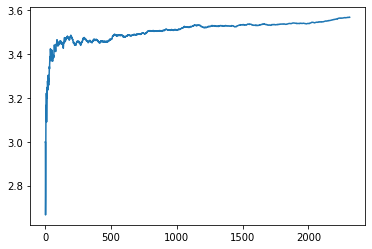

In [47]:
from matplotlib import pyplot as plt
plt.plot(ss)
plt.show()

<BarContainer object of 5 artists>

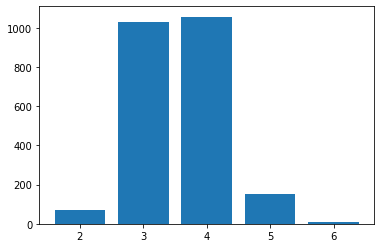

In [48]:
v = C(turn_count)
plt.bar(v.keys(),v.values())

In [49]:
v

Counter({3: 1029, 2: 69, 4: 1056, 5: 150, 6: 10})

In [ ]:
current_score = 0
not_found = 0
pbar = tqdm(enumerate(targets), total=len(targets))
ss2 = []
acc2 = []
turn_count = []
for curr_ind, word in pbar:
    new_targets = targets.copy()
    guess_pool = guesses.copy()
    for turn in range(1,7):
        if turn == 1:
            guess = "salet"
        else:
            if turn >= 4 and len(new_targets) > 2:
                max_t = 0
                guess = new_targets[0]
                for t in new_targets:
                    n = Tree(t,new_targets).size
                    if n > max_t:
                        guess = t
                        max_t = n
            else:
                guess = find_guess(guess_pool, new_targets)
        if word == guess:
            current_score += turn
            turn_count.append(turn)
            break
        if (turn == 6):
            not_found +=1 
            break
        pattern = play_round(guess, word)
        new_targets = reduce_targets(guess, pattern, new_targets)

    ss2.append(current_score/(curr_ind-not_found+1))
    acc2.append(((curr_ind+1-not_found)*100)/(curr_ind+1))
    pbar.set_postfix({'Score': current_score/(curr_ind-not_found+1), 'Accuracy':((curr_ind+1-not_found)*100)/(curr_ind+1)})
    # print(f"SCORE: {current_score/(curr_ind+1-not_found)}, Accuracy = {((curr_ind+1-not_found)*100)/(curr_ind+1)}%", end='\r',flush=True)

 13%|██████▊                                             | 306/2315 [01:11<05:12,  6.43it/s, Score=3.46, Accuracy=99.7]

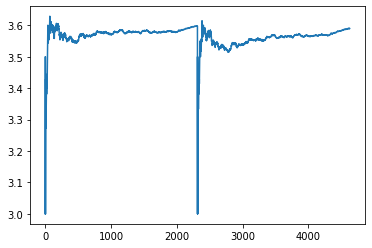

In [33]:
plt.plot(ss2)
# if acc[-1] < 100:
#     plt.plot(acc)
plt.show()

In [35]:
current_score = 0
not_found = 0
pbar = tqdm(enumerate(targets), total=len(targets))
ss2 = []
acc2 = []
turn_count = []
for curr_ind, word in pbar:
    new_targets = targets.copy()
    guess_pool = guesses.copy()
    for turn in range(1,7):
        if turn == 1:
            guess = "salet"
        else:
            if turn >= 3 and len(new_targets) > 2:
                max_t = 0
                guess = new_targets[0]
                for t in new_targets:
                    n = Tree(t,new_targets).size
                    if n > max_t:
                        guess = t
                        max_t = n
            else:
                guess = find_guess(guess_pool, new_targets)
        if word == guess:
            current_score += turn
            turn_count.append(turn)
            break
        if (turn == 6):
            not_found +=1 
            break
        pattern = play_round(guess, word)
        new_targets = reduce_targets(guess, pattern, new_targets)

    ss2.append(current_score/(curr_ind-not_found+1))
    acc2.append(((curr_ind+1-not_found)*100)/(curr_ind+1))
    pbar.set_postfix({'Score': current_score/(curr_ind-not_found+1), 'Accuracy':((curr_ind+1-not_found)*100)/(curr_ind+1)})
    # print(f"SCORE: {current_score/(curr_ind+1-not_found)}, Accuracy = {((curr_ind+1-not_found)*100)/(curr_ind+1)}%", end='\r',flush=True)

  5%|██▌                                                  | 111/2315 [00:31<10:35,  3.47it/s, Score=3.59, Accuracy=100]


KeyboardInterrupt: 

In [19]:
all_outcomes = []
for a in range(3):
    for b in range(3):
        for c in range(3):
            for d in range(3):
                for e in range(3):
                    all_outcomes.append(str(a)+str(b)+str(c)+str(d)+str(e))

targs = reduce_targets("salet", all_outcomes[0], targets)
for tar in targs:
    for outcome in all_outcomes:
        if len(reduce_targets(tar, outcome, targs)) != 0:
            print(len(reduce_targets(tar, outcome, targs)))
    

45
1
16
1
10
1
3
1
25
1
3
10
3
3
1
17
1
1
10
2
4
1
6
4
16
1
3
5
2
1
5
4
2
1
1
1
2
1
1
2
1
1
1
22
24
3
4
3
6
1
1
5
1
13
4
1
5
12
8
1
1
2
7
1
5
2
4
2
3
11
1
3
3
22
4
6
1
3
2
1
2
1
1
1
1
1
1
1
1
2
1
1
1
2
4
2
36
33
4
5
2
21
12
1
2
36
5
8
3
5
1
3
1
1
2
2
1
5
5
1
1
1
2
7
2
2
1
7
1
2
32
2
7
7
16
2
9
2
2
2
2
17
3
6
25
2
1
2
1
34
4
9
4
1
3
1
1
1
19
2
1
1
63
1
3
1
12
25
1
38
1
2
7
3
1
27
6
1
7
1
3
1
2
1
1
10
1
1
1
15
31
2
2
1
3
3
1
29
7
1
1
1
1
6
17
2
3
3
2
12
1
1
1
10
7
1
1
1
1
9
1
2
1
1
1
5
4
9
1
2
4
1
6
3
1
1
2
35
3
6
3
4
1
1
11
2
2
1
18
1
3
8
11
2
2
4
1
5
2
2
3
26
1
6
1
1
1
6
1
4
7
3
1
1
1
1
1
4
3
1
1
6
1
1
4
2
2
1
1
1
42
1
14
1
10
1
4
2
19
1
4
9
3
5
1
13
1
1
10
2
4
1
4
4
14
1
3
2
1
2
1
1
2
1
1
3
1
8
1
11
3
2
2
2
2
29
1
7
3
1
6
4
10
1
1
17
1
4
2
1
11
2
4
2
6
2
1
1
3
19
1
7
1
2
5
1
7
1
1
1
5
2
5
1
1
1
1
1
5
1
2
5
3
2
4
3
3
1
1
1
1
2
1
2
1
46
30
3
2
2
1
1
7
17
5
12
9
1
1
1
3
2
29
7
2
1
7
1
7
5
1
2
2
1
3
1
3
2
4
18
1
34
10
3
3
22
2
6
4
5
11
9
1
2
9
6
1
1
17
1
1
1
2
3
1
4
5
5
5
1
3
2
1
1
1
6
1


1
1
2
2
1
1
6
5
2
1
1
2
1
1
1
2
2
1
12
21
8
4
2
5
5
1
10
9
2
2
8
17
10
8
2
1
14
4
1
1
1
3
1
2
2
1
6
1
7
2
1
1
1
2
2
7
1
2
1
1
2
1
1
1
2
1
2
2
4
1
3
1
2
1
1
1
1
2
17
31
3
1
1
3
2
1
2
1
29
7
6
17
2
2
1
1
2
2
12
1
1
1
2
8
8
1
1
1
2
7
1
2
1
1
1
5
1
3
9
1
2
1
3
1
6
3
2
2
16
17
3
19
4
8
1
1
2
3
6
1
6
4
1
1
4
2
9
11
4
2
3
5
1
1
1
1
1
1
2
13
3
4
1
1
2
1
1
5
1
6
4
1
1
4
14
1
9
1
6
1
19
7
5
2
9
3
4
2
24
4
4
2
2
20
4
3
3
4
6
3
1
3
2
1
25
8
1
8
9
1
1
4
1
1
2
1
1
3
1
1
1
4
1
1
1
2
1
1
1
1
1
1
32
3
9
3
9
1
2
9
1
1
2
31
4
5
8
3
3
3
14
1
1
4
1
2
5
1
1
1
5
2
2
22
1
4
1
4
1
1
2
2
1
1
1
3
4
1
1
1
1
21
1
38
1
1
5
4
5
6
1
3
4
19
1
4
9
2
1
1
2
2
9
1
1
1
13
2
7
1
1
2
1
7
1
3
5
4
1
7
1
1
2
1
2
2
1
1
2
1
1
1
1
1
1
2
2
40
4
10
1
33
9
3
17
1
2
6
1
1
3
25
1
2
5
1
1
2
5
1
3
1
4
1
4
2
2
9
1
4
2
1
1
2
1
2
1
1
1
1
2
1
30
18
11
7
1
8
14
9
1
4
1
9
4
3
6
7
4
1
12
1
2
3
3
11
3
1
2
2
1
1
1
1
1
1
6
3
7
3
1
7
3
1
1
1
1
1
1
1
53
28
2
2
2
1
2
3
7
1
11
15
2
6
1
2
2
17
1
1
3
3
6
6
1
1
1
1
3
11
8
1
1
1
3
1
1
9
1
11
1
25
2
1
4
5


1
1
1
1
5
1
1
1
1
5
1
8
1
1
1
4
1
1
1
8
2
1
1
1
25
1
23
3
2
5
2
1
2
16
2
8
1
9
3
2
10
1
3
4
1
2
10
1
1
3
15
3
5
1
4
2
2
2
1
1
1
2
1
1
1
1
7
1
1
3
1
1
6
2
1
1
2
1
1
2
2
2
1
2
32
27
1
1
3
5
4
12
1
3
12
9
3
10
20
7
2
4
6
1
10
2
4
2
10
4
2
2
1
2
1
2
3
2
1
1
1
2
2
1
1
1
1
23
28
1
1
11
3
1
1
17
9
1
3
19
1
7
2
2
1
17
14
2
1
2
9
1
1
4
6
2
3
3
1
3
1
1
3
3
1
1
2
2
4
1
1
1
19
2
2
5
1
2
9
2
4
1
2
1
1
17
1
6
1
10
1
13
9
3
2
5
2
5
1
1
1
6
1
1
16
4
4
7
1
8
2
9
1
1
2
1
3
1
1
1
1
3
1
1
1
2
1
2
1
1
3
1
1
1
2
66
44
4
2
17
11
1
41
7
3
1
8
4
1
1
1
1
2
3
1
1
1
33
6
58
3
6
2
6
3
2
5
2
7
1
19
1
1
1
6
7
2
1
4
1
11
18
2
2
4
1
1
1
1
1
1
1
32
1
21
2
3
7
2
1
3
17
2
15
3
3
9
6
2
11
1
3
1
4
1
2
11
1
1
4
14
3
7
4
2
4
1
1
1
1
1
1
1
3
2
1
1
1
1
1
1
27
4
31
3
2
2
1
1
20
8
2
3
1
5
1
12
1
2
1
1
4
1
2
1
2
12
4
5
1
26
3
1
3
3
5
2
1
1
1
1
5
1
4
2
2
38
36
3
2
4
2
19
2
1
9
3
13
2
1
1
6
3
1
18
1
1
1
2
6
2
4
1
1
1
1
2
1
1
1
2
4
4
1
2
1
7
4
1
2
3
35
27
1
5
7
5
1
7
4
1
1
6
4
2
8
7
5
2
2
1
6
3
1
1
16
4
4
3
1
13
3
1
4
1
1
2
2
2
1
1


<BarContainer object of 5 artists>

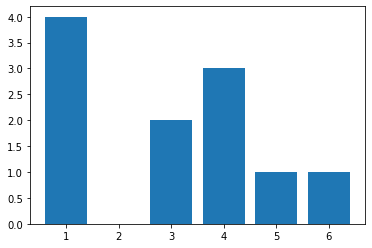

In [43]:
from collections import Counter as C
v = C([1,4,4,4,1,1,1,3,3,5,6])
